In [1]:
!pip install transformers datasets wandb -qq

     |████████████████████████████████| 3.8 MB 7.7 MB/s 
     |████████████████████████████████| 325 kB 35.3 MB/s 
     |████████████████████████████████| 1.7 MB 45.2 MB/s 
     |████████████████████████████████| 6.5 MB 41.5 MB/s 
     |████████████████████████████████| 895 kB 42.4 MB/s 
     |████████████████████████████████| 596 kB 49.7 MB/s 
     |████████████████████████████████| 67 kB 5.4 MB/s 
     |████████████████████████████████| 134 kB 35.5 MB/s 
     |████████████████████████████████| 212 kB 41.9 MB/s 
     |████████████████████████████████| 1.1 MB 48.1 MB/s 
     |████████████████████████████████| 127 kB 65.9 MB/s 
     |████████████████████████████████| 144 kB 59.4 MB/s 
     |████████████████████████████████| 181 kB 55.0 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 271 kB 58.7 MB/s 
     |████████████████████████████████| 144 kB 54.2 MB/s 
     |████████████████████████████████| 94 kB 3.6 MB/s 
ERROR: pip's dependen

Team [LostCow](https://github.com/l-yohai/KLUE)의 roberta모델을 기준으로 함
- pretrained_model : klue/roberta-base
- tokenizer : klue/roberta-base
- dropout : 0.1
- batch_size : 64
- optim : adamw_hf
- learning_rate : 5e-5
- loss_fnc : MSELoss

In [2]:
import json
import tarfile

import pandas as pd
from sklearn.metrics import classification_report,f1_score

import torch
from datasets import load_metric

In [3]:
#GPU 사용 여부 확인 및 name 확인
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"# available GPUs : {torch.cuda.device_count()}")
    print(f"GPU name : {torch.cuda.get_device_name()}")
else:
    device = torch.device("cpu")
print(device)

# available GPUs : 1
GPU name : Tesla P100-PCIE-16GB
cuda


# 학습 및 검증 데이터 불러오기

In [4]:
# 데이터 다운로드
!wget https://aistages-prod-server-public.s3.amazonaws.com/app/Competitions/000067/data/klue-sts-v1.1.tar.gz

--2022-03-18 08:20:25--  https://aistages-prod-server-public.s3.amazonaws.com/app/Competitions/000067/data/klue-sts-v1.1.tar.gz
Resolving aistages-prod-server-public.s3.amazonaws.com (aistages-prod-server-public.s3.amazonaws.com)... 52.92.195.89
Connecting to aistages-prod-server-public.s3.amazonaws.com (aistages-prod-server-public.s3.amazonaws.com)|52.92.195.89|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1349881 (1.3M) [application/x-gzip]
Saving to: ‘klue-sts-v1.1.tar.gz’

klue-sts-v1.1.tar.g 100%[===================>]   1.29M  --.-KB/s    in 0.1s    

2022-03-18 08:20:25 (13.4 MB/s) - ‘klue-sts-v1.1.tar.gz’ saved [1349881/1349881]



In [5]:
# 압출 풀기
tar_bz2_file = tarfile.open("/content/klue-sts-v1.1.tar.gz")
tar_bz2_file.extractall(path="/content")
tar_bz2_file.close()

# 학습 데이터 나누기

In [6]:
#train 데이터셋을 train,valid 데이터셋으로 split

def read_json(file_path):
    with open(file_path) as f:
        return json.load(f)

data=read_json('/content/klue-sts-v1.1/klue-sts-v1.1_train.json')

train_length = int(len(data)*0.9)
train = data[:train_length]
vaild = data[train_length:]

print('data_set:',len(data))
print('train_set:',len(train),', valid_set:',len(vaild))

with open('train_split.json','w') as f:
    json.dump(train,f,ensure_ascii = False)
    
with open('valid_split.json','w') as f:
    json.dump(vaild,f,ensure_ascii = False)

data_set: 11668
train_set: 10501 , valid_set: 1167


# 학습 코드 불러오기

## 수정한 모델 소개

모델의 FClayer 층이 참고하는 roberta model의 hidden states를 다각화 하여 성능을 향상시켰습니다.

base model로 선정한 LostCow team의 FClayer층의 학습 방식은 roberta model이 문장A,B에 대해서 token_type_ids 값을 입력하지 않고 구분되지 않은 상태로 학습시키며 마지막 layer의 임베딩벡터를 문장A,B의 위치를 마스킹해둔 s1_mask, s2_mask를 이용하여 분리한뒤 각 단어들의 dim의 위치값을 평균내어 하나의 토큰 임베딩 값으로 생성한 후 FClayer를 통해 연산됩니다.

이 때문에 roberta model의 pooled_output을 사용하지 않으며 사용시에도 성능 향상에 기여하지 못합니다.

각 문장의 임베딩 벡터의 평균값을 기준으로 FClayer의 연산이 이루어지는 점을 이용하여 각 문장의 의미가 적당하게 고려된 hidden_states layer를 탐색하여 2,3layer의 hidden_states를 추가로 concat하는 것으로 모델의 성능을 향상시켰습니다.

변경 전
```python
  -------------------base model(model.forward code)----------------------
        outputs = self.roberta(
            input_ids, attention_mask=attention_mask, token_type_ids=None
        )
        sequence_output = outputs[0]
        pooled_output = outputs[1]
        s1_h = self.entity_average(sequence_output, s1_mask)
        s2_h = self.entity_average(sequence_output, s2_mask)
        s1_h = self.sentence_fc_layer(s1_h)
        s2_h = self.sentence_fc_layer(s2_h)

        concat_h = torch.cat([s1_h, s2_h], dim=-1)
        concat_h = self.dense(concat_h)

        logits = self.label_classifier(concat_h)

        outputs = (logits,) + outputs[2:]
```

변경 후
```python
      ----------------custom model(model.forward code)---------------------

        outputs = self.roberta(
            input_ids, attention_mask=attention_mask, token_type_ids=None, output_hidden_states=True
        )

        sequence_output = outputs[0]
        pooled_output = outputs[1]
        s1_h = self.entity_average(sequence_output, s1_mask)
        s2_h = self.entity_average(sequence_output, s2_mask)
        s1_h = self.sentence_fc_layer(s1_h)
        s2_h = self.sentence_fc_layer(s2_h)
        
        sequence_output_sec_layer=outputs['hidden_states'][2]
        ss1_h = self.entity_average(sequence_output_sec_layer, s1_mask)
        ss2_h = self.entity_average(sequence_output_sec_layer, s2_mask)
        ss1_h = self.sentence_fc_layer2(ss1_h)
        ss2_h = self.sentence_fc_layer2(ss2_h)

        sequence_output_sec_layer2=outputs['hidden_states'][3]
        sss1_h = self.entity_average(sequence_output_sec_layer2, s1_mask)
        sss2_h = self.entity_average(sequence_output_sec_layer2, s2_mask)
        sss1_h = self.sentence_fc_layer3(sss1_h)
        sss2_h = self.sentence_fc_layer3(sss2_h)

        concat_h = torch.cat([s1_h, s2_h,ss1_h, ss2_h,sss1_h, sss2_h], dim=-1)
        concat_h = self.dense(concat_h)
        concat_h = self.dense2(concat_h)
        logits = self.label_classifier(concat_h)

        outputs = (logits,) + ()

```

학습 파라미터 설명
- `save_steps`을 100으로 설정한 것을 제외하곤 default 값으로 학습하였다.

```python
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    # data_arg
    parser.add_argument("--data_dir", type=str, default="./data")
    parser.add_argument("--model_dir", type=str, default="./model")
    parser.add_argument("--output_dir", type=str, default="./output")
    parser.add_argument("--model_name_or_path", type=str, default="klue/roberta-large")
    parser.add_argument("--train_filename", type=str, default="klue-sts-v1.1_train.json")
    parser.add_argument("--valid_filename", type=str, default="klue-sts-v1.1_dev.json")

    # train_arg
    parser.add_argument("--num_labels", type=int, default=1)
    parser.add_argument("--seed", type=int, default=42)
    parser.add_argument("--num_train_epochs", type=int, default=10)
    parser.add_argument("--batch_size", type=int, default=64)
    parser.add_argument("--learning_rate", type=float, default=5e-5)
    parser.add_argument("--gradient_accumulation_steps", type=int, default=1)
    parser.add_argument("--weight_decay", type=float, default=0.01)
    parser.add_argument("--max_seq_length", type=int, default=110)

    # eval_arg
    parser.add_argument("--evaluation_strategy", type=str, default="steps")
    parser.add_argument("--save_steps", type=int, default=250) # 100 steps
    parser.add_argument("--save_total_limit", type=int, default=2)

    # wandb_log
    parser.add_argument("--wandb_entity", type=str, default='wanted_ai_06') # 수정 불필요
    parser.add_argument("--wandb_project", type=str, default='sohn_assign3') # 영어성씨_assign3로 수정할 것

    args = parser.parse_args()
    main(args)
```

# 모델 학습

In [7]:
# 수정한 모델 불러오기
!git clone https://github.com/wanted-AI-06/Assignment-03

Cloning into 'Assignment-03'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 63 (delta 23), reused 44 (delta 11), pack-reused 0
Unpacking objects: 100% (63/63), done.


In [8]:
!python /content/Assignment-03/code/train.py --data_dir /content --model_name_or_path "klue/roberta-base" --train_filename "train_split.json" --valid_filename "valid_split.json" --num_train_epochs 10 --save_steps 100 

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: 2
wandb: You chose 'Use an existing W&B account'
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: wanted_ai_06 (use `wandb login --relogin` to force relogin)
wandb: Tracking run with wandb version 0.12.11
wandb: Run data is saved locally in /content/wandb/run-20220318_082354-3spy8l32
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run daily-tree-21
wandb: ⭐️ View project at https://wandb.ai/wanted_ai_06/sohn_assign3
wandb: 🚀 View run at https://wandb.ai/wanted_ai_06/sohn_assign3/runs/3spy8l32
Downloading: 100% 546/546 [00:00<00:00, 480kB/s]
Downloading: 100% 375/375 [00:00<00:00, 300kB/s]
Downloading: 100% 243k/243k [00:00<0

[WandB 로깅 기록 바로가기](https://wandb.ai/wanted_ai_06/sohn_assign3/runs/3spy8l32?workspace=user-arc)

## 모델 테스트


In [9]:
mv /content/klue-sts-v1.1.tar.gz /content/model/klue-sts-v1.1.tar.gz

In [10]:
#학습한 모델을 이용하여 dev_set 예측값 출력(real_label)
!python /content/Assignment-03/code/inference.py --test_filename "/content/klue-sts-v1.1/klue-sts-v1.1_dev.json" --output_dir "/content"  --model_tar_file "klue-sts-v1.1.tar.gz"

In [30]:
#valid의 label 값을 추출
valid_data=read_json('/content/klue-sts-v1.1/klue-sts-v1.1_dev.json')
valid_label=[data['labels']['binary-label'] for data in valid_data]


#Regression pred 를 binary-label pred로 변환 후 혼동 행렬 및 f1_score 시각화
df_pred = pd.read_csv('/content/output.csv',header=None)

pred=(df_pred>2.5).astype(int)
print("epochs 10 / >2.5")
print(classification_report(valid_label, pred))
print('custom_model(roberta-base) f1_score:',f1_score(valid_label, pred), end='\n\n')

pred=(df_pred>3).astype(int)
print("epochs 10 / >3")
print(classification_report(valid_label, pred))
print('custom_model(roberta-base) f1_score:',f1_score(valid_label, pred))

epochs 10 / >2.5
              precision    recall  f1-score   support

           0       1.00      0.69      0.81       299
           1       0.70      1.00      0.82       220

    accuracy                           0.82       519
   macro avg       0.85      0.84      0.82       519
weighted avg       0.87      0.82      0.82       519

custom_model(roberta-base) f1_score: 0.8217636022514071

epochs 10 / >3
              precision    recall  f1-score   support

           0       0.96      0.79      0.86       299
           1       0.77      0.95      0.85       220

    accuracy                           0.86       519
   macro avg       0.86      0.87      0.86       519
weighted avg       0.87      0.86      0.86       519

custom_model(roberta-base) f1_score: 0.8478701825557808


In [32]:
#dev_set에 대한 pearsonr score 출력 
df_pred = pd.read_csv('/content/output.csv',header=None)
valid_data=read_json('/content/klue-sts-v1.1/klue-sts-v1.1_dev.json')
valid_label=[data['labels']['real-label'] for data in valid_data]

pearson = load_metric("pearsonr").compute
metric = pearson(predictions=df_pred.to_numpy(), references=valid_label)
print(metric)

{'pearsonr': 0.8869273898083346}


# 모델 성능 비교

|모델 특징|전처리 유무|dev peasonr score|dev f1 score|
|:---|:---:|:---:|:---:|
|custom|X|0.887 ~ 0.898|0.848 ~ 0.864|
|custom|영어, 숫자, 특수문자 전처리|0.847|0.835|
|custom|영어만 소문자 처리|0.808|0.823|

전처리를 통한 성능 감소를 확인 하였고 전처리를 진행하지 않고 학습시킨 custom 모델을 최종 선정하였습니다.

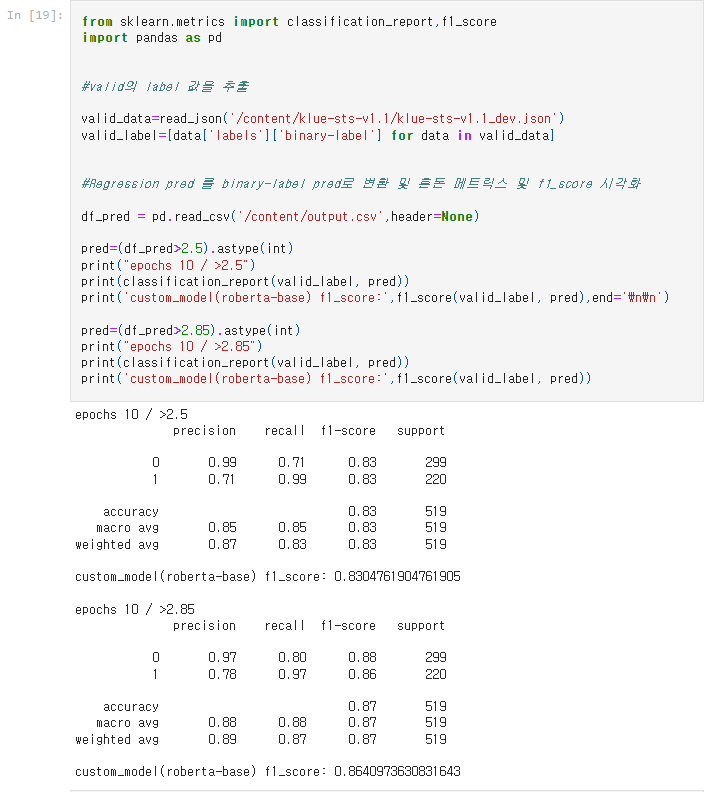

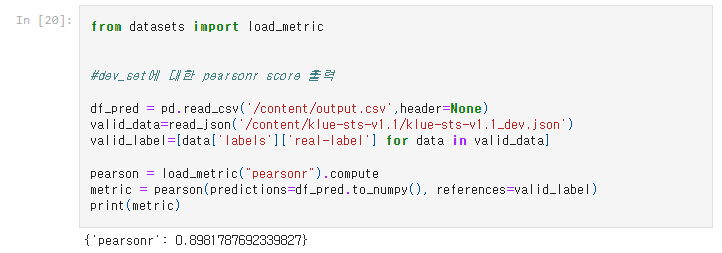